# Module 1 - Moment and Cumulant Reconstructions

In this notebook, we demonstrate how to use **pysofi** to calculate moment and cumulant reconstructions. We show how different parameters can be determined and tuned based on the data and the user's needs. 

## 1. Load data (Tiff Files) into Data object.

The input data can be videos (tiff image stacks) from simulations or fluorescence imaging experiements. In this notebook, we use data from Hela cells transfected with Dronpa-C12 (fluorescent protein) fused to β-Actin. Live cells were imaged with 30 ms frame integration and 200 frames in total.

There are two ways to calculate moment and cumulant reconstructions using **pysofi**. We will start with the first one. We can load the data into the <code>Data</code> class first, and calculate moments and culumants by calling the corresponding methods.

Here, <code>average_image()</code> and <code>get_frame(frame_num)</code> are also used to how we get the average image and a specfic frame of the video. More details about the Data object and its methods are [here]((https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/functions/data.py)).

Loading BokehJS ...

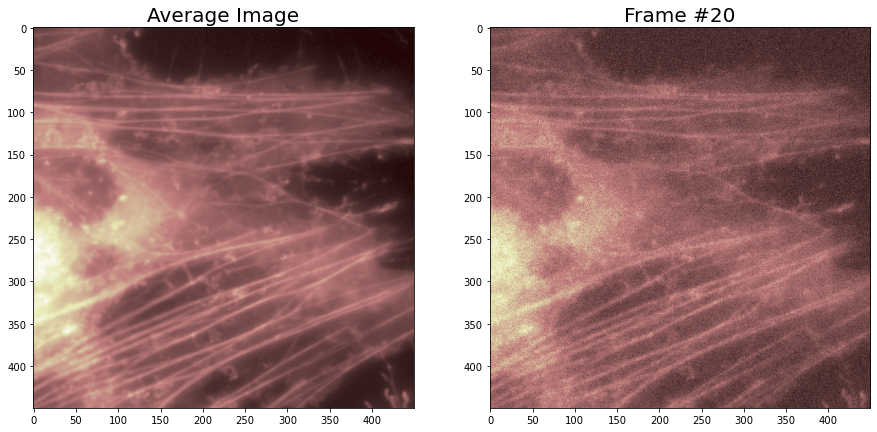

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import visualization as v
from functions import data

# load data into Data object
filepath = '../sampledata'
filename = 'Block1.tif'
d = data.Data(filepath, filename)

# Calculate and show average image and frame #20
mean_im = d.average_image()
frame_im = d.get_frame(20)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].set_title('Average Image', fontsize=20)
axs[0].imshow(mean_im, cmap='pink')
axs[1].set_title('Frame #20', fontsize=20)
axs[1].imshow(frame_im, cmap='pink')
plt.show()

## 2. Calculate moment reconstructions.

Traditionally, the resolution enhancement of [SOFI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2799731/) is manifested by the reduced width of the point spread function (PSF) in the cumulants-reconstructed SOFI image. 

However, one reason that limits the resolution enhancement of high-order SOFI is the positive and negative oscillations of the cumulants. The boundaries between the negative and positive regions generates “[cusp artifacts](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585)” in high-order cumulant-reconstructed images. 

A practical (but mathematically nonrigorous) solution to avoid cusp artifacts is to use [moments reconstruction](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-10-5-2430&id=409047). Even-order moments are always positive and immune to cusp artifacts while keeping the resolution enhancement. 

Since cumulant and moment are interchangable, we can easily get cumulants-reconstructed images after moments reconstruction. With **pysofi**, we can either (1) get a single reconstruction with a specific order, or (2) calculate a set of recontructions up to a user-defined highest order.

(1) <code>d.moment_image</code> is a method of the Data object that calculates the moment-reconstructed image of a specific order for the input video. We can pass 
+ <code>order=4</code>: the order of moment reconstruction
+ <code>mvlength=[0,200]</code>: the range of frames if we do not need to process the whole video. If not defined, the whole video is calculated. 
+ <code>finterp=False, interp_num=1</code>: whether to incorporate [Fourier interpolation]() in the moment reconstruction and the interpolation factor.

The moments-reconstructed image is saved as an attribute of the Data object.

In [2]:
m_im = d.moment_image(6)
m_im_finterp = d.moment_image(order=4, mvlength=[50,100], finterp=True, interp_num=2)

[==============================] 100.0%

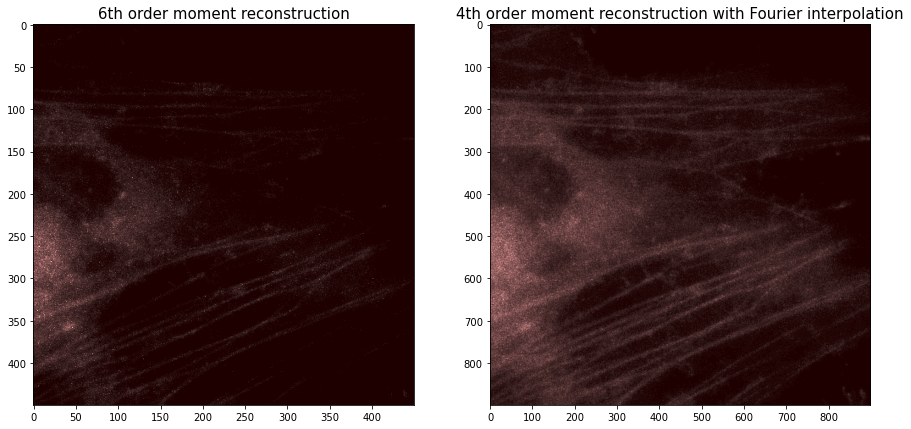

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].set_title('6th order moment reconstruction', fontsize=15)
axs[0].imshow(m_im, cmap='pink')
axs[1].set_title('4th order moment reconstruction with Fourier interpolation', fontsize=15)
axs[1].imshow(m_im_finterp, cmap='pink')
plt.show()

(2) <code>d.calc_moments_set</code> calculates all moment reconstructions up to a user-defined highest order. We can set <code>highest_order=4</code>. The result images are saved in a dictionary, with order numbers as keys and images as values.

dict_keys([1, 2, 3, 4])


Text(0.5, 1.0, '4th order moment reconstruction')

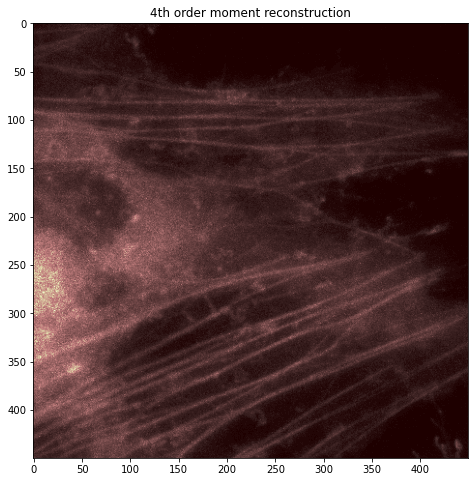

In [9]:
m_set = d.calc_moments_set(highest_order=4)

print(m_set.keys())
plt.figure(figsize = (8,8))
plt.imshow(m_set[4], cmap='pink')
plt.title('4th order moment reconstruction')

## 3. Calculate cumulant reconstructions.

Cumulant-reconstructed images can be derived from moment reconstructions. The highest order of cumulants is calculated by building up on lower order moments and [cumulants](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-10-5-2430&id=409047). 

In **pysofi**, <code>d.cumulants_images</code> calculates all cumulant reconstructions up to a user-defined highest order. The highest cumulant order does not need to match the highest moment order inputed previously, pysofi can identify the difference, and autometically calculate extra order of reconstructions.

dict_keys([1, 2, 3, 4, 5])


Text(0.5, 1.0, '2rd order cumulant reconstruction')

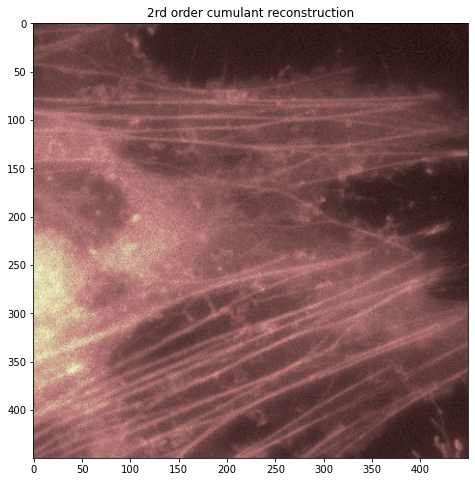

In [16]:
k_set = d.cumulants_images(highest_order=5)

print(k_set.keys())
plt.figure(figsize = (8,8))
plt.imshow(k_set[2], cmap='pink')
plt.title('2rd order cumulant reconstruction')

Here we want to note that high-order (>2) cumulant of each pixel can oscillate between positive and negative based on the time trajectory. The boundaries between the negative and positive regions can generate [cusp artifacts](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585), which hinders the resolution enhancement.

## 4. Moment and cumulant reconstructions with <code>reconstruction</code>.

The second way to calculate moment and cumulant reconstructions using pysofi is to call the following functions directly from <code>reconstruction.py</code>. This way is for users who prefer a quick reconstruction without need for other Data methods like [noise filtering]() and [LDRC]().

+ <code>average_image</code>: average image 
+ <code>calc_moment_im</code>: moment-reconstructed image of a specific order
+ <code>calc_moments</code>: all moment reconstructions up to a user-defined highest order
+ <code>calc_cumulants_from_moments</code>: all cumulant reconstructions up to a user-defined highest order from moment reconstructions

[=============================] 100.0%

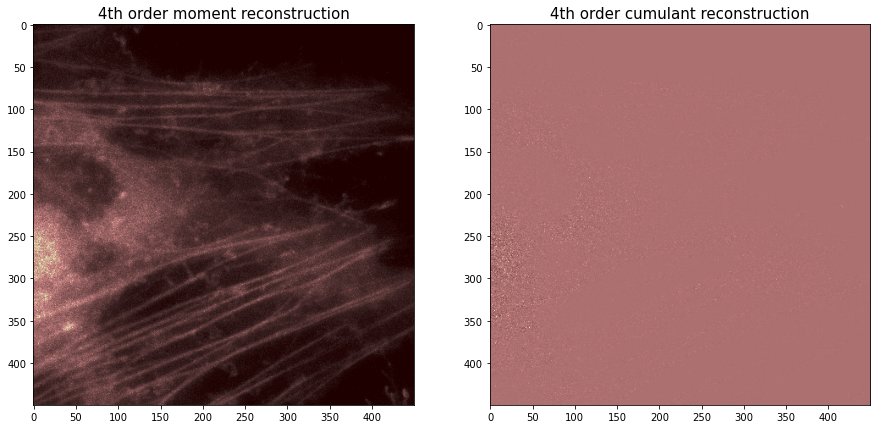

In [18]:
from functions import reconstruction as rec
filepath = '../sampledata'
filename = 'Block1.tif'

# Calculate average image, 6th order moment-reconstructed image, 
# all moments and culumants up to 7th order
ave_im = rec.average_image(filepath, filename, frames=[0,150])
m6 = rec.calc_moment_im(filepath, filename, order=6, frames=[0,150])
m_set = rec.calc_moments(filepath, filename, 4)
k_set = rec.calc_cumulants_from_moments(m_set)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].set_title('4th order moment reconstruction', fontsize=15)
axs[0].imshow(m_set[4], cmap='pink')
axs[1].set_title('4th order cumulant reconstruction', fontsize=15)
axs[1].imshow(k_set[4], cmap='pink')
plt.show()

The user can also explore moment and cumulant reconstructions with this notebook and provided [simulations](https://github.com/xiyuyi-at-LLNL/pysofi/tree/master/sampledata/simulations).